In [1]:
using Plots, StatsBase, LinearAlgebra, Statistics, JLD2, Dates, StaticArrays, JSON, CUDA

# data structure module
include("spin_sim_functions.jl")
using .spin_sim_functions

# function libraries
# include("spin_sims_new.jl");

In [2]:
## ONLY WORKS FOR BOTH DISSIPATION AND LOCAL M

include("liouville_tools.jl")
using .LiouvilleTools
using LinearAlgebra
using CUDA

function spin_echo_sim(params)
    
    # initialize M_list
    M_list = [];
    
    U90 = params["U90"];
    
    # 90 pulse
    ψ_list = [U90*ψ for ψ in params["ψ_init"]];
    
    # first tau
    t0 = 0.0;
    ψ_list, M_list, t1 = time_propagate(ψ_list, M_list, t0, params["dt"], params["nτ"], params)
    
    # 180 pulse
    ψ_list = [U90*U90*ψ for ψ in ψ_list];
        
    # second tau
    ψ_list, M_list, t2 = time_propagate(ψ_list, M_list, t1, params["dt"], 2*params["nτ"], params)
    
  return M_list

end

function time_propagate(ψ_list, M_list, t0, dt, nsteps, params)
        
    # spectrum info
    ν0 = params["ν0"] # central freq.
    ν = params["ν"] # spin freqs.
    P = CuArray(params["P"]) # spin weights
    nS = params["nfreq"] # number of spins
    r = params["r"] # positions of spins
    
    # operators
    M_op = params["M_op"]
    Iz = params["Iz"]
    
    # additional values
    n = params["n"]
    pbc = params["pbc"]
    spin_idx = params["spin_idx"]
    
    # experiment parameters
    α = params["α"]
    
    # initial time
    t = t0;

    # initial magnetization    
    M_eval = [tr(M_op*ψ*ψ') for ψ in ψ_list]
    M_eval = CuArray(M_eval)
    M = sum(P.*M_eval);
    
    # prepare the stencils
    M_stencil = params["M_stencil"]
    M_stencil_vec = shift_stencil_pbc(M_stencil, P, spin_idx, n)

    # calculate the local magnetization ### HAVE TO FIX FOR DIFF DIMENSION MESHES
    M_eval = repeat(M_eval, 1, 1, n[1], n[2])
    M_eval .*= M_stencil_vec # multiply
    M_local = mapreduce(identity, +, M_eval; dims = [1,2])
    M_local = dropdims(M_local, dims = (1,2))
    
    # time evolve
    for idx = 1:nsteps
        
        t += dt;
            
        # convert to array type
        M_local = Array(M_local)

        # calculate interaction
        Oprime = map(x -> (1/4)*[0 conj(x); x 0] - (1/4)*[0 x*exp(-2im*ν0*t); conj(x)*exp(2im*ν0*t) 0], M_local)
        int = α*Oprime

        # calculate propagators
        H = -(ν.-ν0).*[Iz] .- int
        U = map(exp, -1im*H*dt)
        
        # time evolve
        ψ_list = U.*ψ_list;
        
        # calculate local M, convert to CuArray type
        M_eval = [tr(M_op*ψ*ψ') for ψ in ψ_list]
        M_eval = CuArray(M_eval)
        
        # calculate global M and save
        M = sum(P.*M_eval);
        push!(M_list, M);

        # local Magnetization update ### HAVE TO FIX FOR DIFF DIMENSION MESHES
        M_eval = repeat(M_eval, 1, 1, n[1], n[2])
        M_eval .*= M_stencil_vec # multiply
        M_local = mapreduce(identity, +, M_eval; dims = [1,2])
        M_local = dropdims(M_local, dims = (1,2))
                
    end
    
    return ψ_list, M_list, t
    
end

function spin_echo_sim_liouville(params)   
    
    # initialize M_list
    M_list = [];
    
    UL90 = params["U90"];
    UR90 = UL90'
    
    UL180 = params["U180"];
    UR180 = UL180'
    
    # 90 pulse
    ψ_list = [UL90*ψ for ψ in params["ψ_init"]];
    
    # convert to liouville space
    ρ_list_L = [dm_H2L(ψ*ψ') for ψ in ψ_list];    
    
    # first tau
    t0 = 0.0;
    ρ_list_L, M_list, t1 = time_propagate_liouville(ρ_list_L, M_list, t0, params["dt"], params["nτ"], params)
    
    # 180 pulse
    ρ_list_L = [dm_H2L(UL180* dm_L2H(ρ_L) *UR180) for ρ_L in ρ_list_L];
        
    # second tau
    ρ_list_L, M_list, t2 = time_propagate_liouville(ρ_list_L, M_list, t1, params["dt"], 2*params["nτ"], params)
    
  return M_list

end

function spin_echo_sim_liouville_cpmg(params)   
    
    # initialize M_list
    M_list = [];
    
    UL90 = params["U90"];
    UR90 = UL90'
    
    UL180 = params["U180"];
    UR180 = UL180'
    
    # 90 pulse
    ψ_list = [UL90*ψ for ψ in params["ψ_init"]];
    
    # convert to liouville space
    ρ_list_L = [dm_H2L(ψ*ψ') for ψ in ψ_list];
    
    # initial time
    t0 = 0.0;
    nτ = convert(Int64, round(params["echo_time"]*params["γ"]/params["dt"]));
    
    # an array which holds the echoes individually
    echoes = Array{Any}(undef, params["num_echoes"], nτ);
    
    # fid
    ρ_list_L, M_list, t1 = time_propagate_liouville(ρ_list_L, M_list, t0, params["dt"], convert(Int64, round(nτ/2)), params)

    # update t0
    t0 = t1;

    
    ρ_list_L = [dm_H2L(UL180* dm_L2H(ρ_L) *UR180) for ρ_L in ρ_list_L];
    
    for echo_idx = 1:params["num_echoes"]
    
        # echo
        ρ_list_L, M_list, t1 = time_propagate_liouville(ρ_list_L, M_list, t0, params["dt"], nτ, params)

        # 180 pulse
        ρ_list_L = [dm_H2L(UL180* dm_L2H(ρ_L) *UR180) for ρ_L in ρ_list_L];
        
        # update time
        t0 = t1;
        
        # save echo
        t0_idx = convert(Int64, round(nτ/2)) + (echo_idx-1)*nτ + 1
        tf_idx = convert(Int64, round(nτ/2)) + echo_idx*nτ
        echoes[echo_idx,:] = M_list[t0_idx:tf_idx];

    end
    
  return M_list, echoes

end

function time_propagate_liouville(ρ_list_L, M_list, t0, dt, nsteps, params) 
            
    # spectrum info
    ν0 = params["ν0"] # central freq.
    ν = params["ν"] # spin freqs.
    P = CuArray(params["P"]) # spin weights
    nS = params["nfreq"] # number of spins
    
    # operators
    M_op = params["M_op"]
    Iz = params["Iz"]
    
    # additional values
    n = params["n"]
    pbc = params["pbc"]
    spin_idx = params["spin_idx"]
    
    # interaction parameters
    α = params["α"]
    
    # initial time
    t = t0;

    # jump operators
    Lj_list = params["Lj"]
    J_L = JumpsToSuper(Lj_list) # get dissipative super operator (assumed constant in time)
  
    # initial magnetization    
    M_L = leftop_H2L(M_op)
    M_eval = [tr_L(M_L*ρ) for ρ in ρ_list_L]
    M_eval = CuArray(M_eval)
    M = sum(P.*M_eval);

    # prepare the stencils
    M_stencil = params["M_stencil"]
    M_stencil_vec = shift_stencil_pbc(M_stencil, P, spin_idx, n)

    # calculate the local magnetization ### HAVE TO FIX FOR DIFF DIMENSION MESHES
    M_eval = repeat(M_eval, 1, 1, n[1], n[2])
    M_eval .*= M_stencil_vec # multiply
    M_local = mapreduce(identity, +, M_eval; dims = [1,2])
    M_local = dropdims(M_local, dims = (1,2))
    
    # time evolve
    for idx = 1:nsteps
        
        t += dt;
        
        # convert to array type
        M_local = Array(M_local)
        
        # calculate interaction
        int = α*map(x -> (1/4)*[0 conj(x); x 0] - (1/4)*[0 x*exp(-2im*ν0*t); conj(x)*exp(2im*ν0*t) 0], M_local)
        
        # calculate hamiltonian
        H_H = -(ν.-ν0).*[Iz] .- int
        H_L = [HamToSuper(H) for H in H_H]
        
        # calculate propagators, adding in dissipation
        U_L = [exp(( -1im*H + J_L )*dt) for H in H_L]
        
        # time evolve
        ρ_list_L = U_L.*ρ_list_L
        
        # update M and save value
        M_eval = [tr_L(M_L*ρ) for ρ in ρ_list_L]
        M_eval = CuArray(M_eval)
        M = sum(P.*M_eval);
        push!(M_list, M)

        # local Magnetization update ### HAVE TO FIX FOR DIFF DIMENSION MESHES
        M_eval = repeat(M_eval, 1, 1, n[1], n[2])
        M_eval .*= M_stencil_vec # multiply
        M_local = mapreduce(identity, +, M_eval; dims = [1,2])
        M_local = dropdims(M_local, dims = (1,2))
        
    end
        
    return ρ_list_L, M_list, t
    
end


function getOprime(t, M, params)
    
    # interaction parameters
    ν0 = params["ν0"]
    
    # Oprime = (1im/2)*[0 -exp(-1im*ν0*t); exp(1im*ν0*t) 0]; # Iy
    Oprime = [(1/4)*[0 conj(x); x 0] - (1/4)*[0 x*exp(-2im*ν0*t); conj(x)*exp(2im*ν0*t) 0] for x in M]; # IyMy
    # Oprime = (1im/4)*[0 -conj(M); M 0] + (1im/4)*[0 -M*exp(-2im*ν0*t); conj(M)*exp(2im*ν0*t) 0]; # IyMx
    # Oprime = (1im/4)*[0 conj(M); -M 0] + (1im/4)*[0 -M*exp(-2im*ν0*t); conj(M)*exp(2im*ν0*t) 0]; # IxMy
    # Oprime = (1/4)*[0 conj(M); M 0] + (1/4)*[0 M*exp(-2im*ν0*t); conj(M)*exp(2im*ν0*t) 0]; #IxMx
    
    return Oprime
    
end

getOprime (generic function with 1 method)

# SET VARIABLES

In [3]:
# interaction
# α = round.(collect(LinRange(0.1, 0.2, 6)), digits = 2)
# pushfirst!(α, 0)
α = 0.01;

# number of frequencies
n = (75, 75)

# make the parameter file
params = make_params(α, n);

# make a lattice, pbc = periodic bc or not
hlk = [1; 1]
θ = [π/2]
pbc = true;
r, spin_idx = make_lattice(hlk, θ, n, pbc);
params["spin_idx"] = spin_idx
params["pbc"] = pbc

# make the stencil
# ξ = correlation length, (hlk, θ, n, r) = lattice parameters, pbc = periodic bc or not, p = decay pow (1/r^p)
# for sparse: t1 = threshold for starting decay, t2 = cutoff to go to zero, cutoff = exp(-(d_coeff*r)^d_pow)
t1 = 0.1
t2 = 0.01
d_pow = 2
d_coef = 0.75
ξ = 10;
p = 4;
stencil = make_stencil(hlk, θ, n, r, ξ, pbc, p);
# s_stencil = make_sparse_stencil(r, ξ, n, t1, t2, d_pow, d_coef)
params["M_stencil"] = stencil;
params["ξ"] = ξ

# load dissipation parameters
Γ = (0, 0, 10^-3);
params["Γ"] = Γ

# load the pulsing parameters
# f = collect(LinRange(0.1, 2, 11))
ϕ = (0, π/2)
Ix = convert.(Complex{Float32}, @SArray [0 1/2; 1/2 0])
Iy = convert.(Complex{Float32}, @SArray [0 -1im/2; 1im/2 0]);

coef90 = Ix*cos(ϕ[1]) + Iy*sin(ϕ[1])
coef180 = Ix*cos(ϕ[2]) + Iy*sin(ϕ[2])
U90 = convert.(Complex{Float32}, exp(-1im*pi*coef90/2));
U180 = convert.(Complex{Float32}, exp(-1im*pi*coef180));
    
params["U90"] = U90
params["U180"] = U180
# params["f"] = f;

# load τ list
# τ = exp10.(LinRange(-5, log10(600e-6), 10));
# params["τ"] = τ;

# cpmg parameters
echo_time = collect(LinRange(50e-6, 300e-6, 20));
num_echoes = unique(convert.(Int64, round.(1500e-6./echo_time)));
echo_time = round.(round.(1500 ./num_echoes)*1e-6, digits = 6);
params["echo_time"] = echo_time;
params["num_echoes"] = num_echoes;

In [4]:
M_list_big = Array{Any}(undef, 14)
echoes_big = Array{Any}(undef, 14)

for i = 1:14
    str1 = "cpmg_vary_α_0p05_vary_te_M_list_1_"*string(i)*".jld2"
    str2 = "cpmg_vary_α_0p05_vary_te_echoes_1_"*string(i)*".jld2"
    
    @load str1 M_list
    @load str2 echoes
    
    M_list_big[i] = M_list
    echoes_big[i] = echoes
end

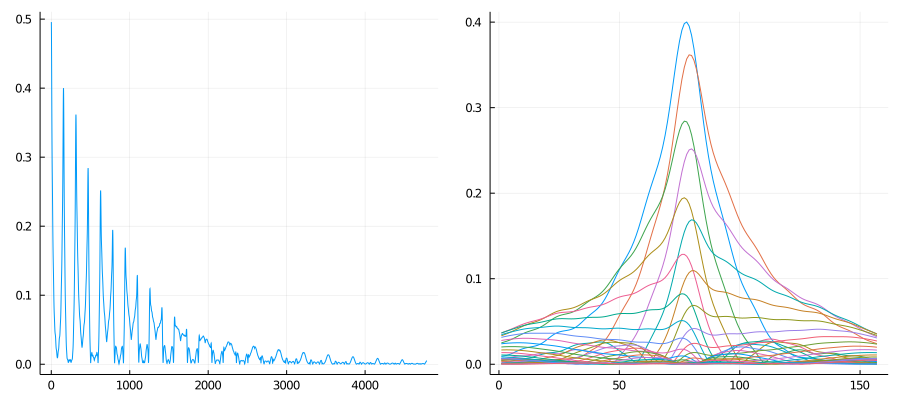

In [19]:
idx = 1
p1 = plot(leg = false)
plot!(p1, broadcast(abs, M_list_big[idx]))
p2 = plot(leg = false)

echoes_to_plot = echoes_big[idx]
for i = 1:size(echoes_to_plot,1)
    plot!(p2, broadcast.(abs, echoes_to_plot[i,:]))
end

plt = plot(p1, p2, size = (900, 400))
display(plt)

# ASSIGN VARIABLES TO PARAMETER FILE

In [5]:
# set variables
vars = [("echo_time", "num_echoes")];
params["vars"] = vars;

In [11]:
idx_list, d = make_idx(vars, params)
# M_list = Array{Any}(undef, d)
# echoes = Array{Any}(undef, d)

idx = 14
i = idx_list[idx]

# for i in idx_list

# generate temporary parameters
tparams = make_temp_params(params, vars, i)

# simulate
@time M_list, echoes = spin_echo_sim_liouville_cpmg(tparams);

str1 = "cpmg_vary_α_0p01_vary_te_M_list_"*string(i[1])*".jld2"
str2 = "cpmg_vary_α_0p01_vary_te_echoes_"*string(i[1])*".jld2"

@save str1 M_list
@save str2 echoes

# end

#=
fname = "cpmg_vary_α_0_vary_te_params.json"
open(fname,"w") do f
    JSON.print(f, params)
end
=#

344.271300 seconds (1.11 G allocations: 79.607 GiB, 3.08% gc time)


In [ ]:
@save "cpmg_vary_α_0_0p01_vary_te_M_list.jld2" M_list
@save "cpmg_vary_α_0_0p01_vary_te_echoes.jld2" echoes

fname = "cpmg_vary_α_0_0p01_vary_te_params.json"
open(fname,"w") do f
    JSON.print(f, params)
end

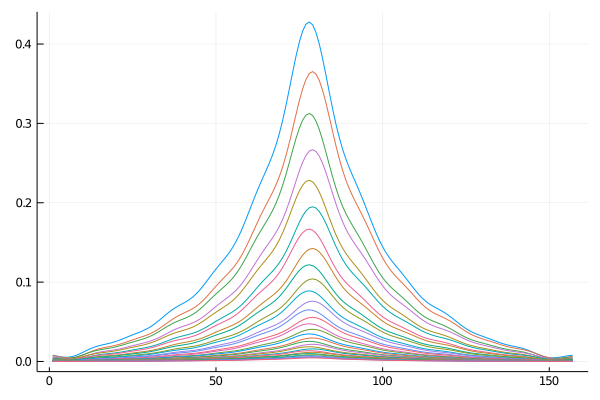

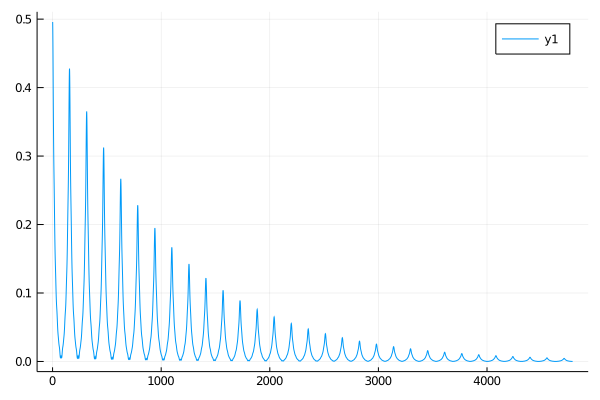

In [12]:
S = broadcast(abs, echoes[1]);
p = plot(leg = false)
for idx = 1:size(echoes[1], 1)
    plot!(S[idx,:])
end
display(p)

plot(broadcast(abs, M_list[1]))

In [142]:
@load "cpmg_α_0p0_M_list.jld2" M_list

echo_ints = Array{Any}(undef, 20)
locs = Array{Any}(undef, 20)

for idx = 1:20
    
    temp = []
    temp_l = []
    
    t = LinRange(0, echo_time[idx]*params["num_echoes"][idx], size(M_list[idx],1))
    nτ = convert(Int64, round(echo_time[idx]*params["γ"]/params["dt"]));
    S = broadcast(abs, M_list[idx])
    
    r0 = convert(Int64, round(nτ/2));
    # push!(temp, sum(2*S[1:r0]))
    push!(temp, maximum(S[1:r0]))
    loc_idx = findall(f -> f == maximum(S[1:r0]), S)[1]
    push!(temp_l, t[loc_idx])

    for i = 1:params["num_echoes"][idx]
        r0 = convert(Int64, round(nτ/2));
        r1 = (r0 + (i-1)*nτ)
        rf = (r0 + i*nτ)
        # amp = sum(S[r1:rf])
        amp = maximum(S[r1:rf]) 
        push!(temp, amp)
        loc_idx = findall(f -> f == maximum(S[r1:rf]), S)[1]
        push!(temp_l, t[loc_idx])
    end
    
    locs[idx] = temp_l
    echo_ints[idx] = temp;

end

Any[0.0, 4.856904115312304e-5, 9.807812826404848e-5, 0.00014696051806977232, 0.00019646960518069774, 0.0002453519949864216, 0.000294861082097347, 0.00034374347190307085, 0.0003932525590139963, 0.00044213494881972006, 0.0004916440359306456, 0.0005405264257363693, 0.0005900355128472947, 0.0006389179026530187, 0.000688426989763944, 0.0007373093795696679, 0.0007868184666805934, 0.0008357008564863171, 0.0008852099435972425, 0.0009340923334029663, 0.0009836014205138917, 0.0010324838103196155, 0.001081992897430541, 0.001130875287236265, 0.0011803843743471902, 0.0012292667641529142, 0.0012787758512638396, 0.0013276582410695634, 0.001377167328180489, 0.0014260497179862128, 0.0014755588050971381]
Any[0.0, 6.156918068366793e-5, 0.0001234508952794357, 0.00018533260987520345, 0.0002472143244709712, 0.000309096039066739, 0.00037097775366250673, 0.0004328594682582745, 0.0004947411828540423, 0.0005566228974498101, 0.0006185046120455778, 0.0006803863266413455, 0.0007422680412371133, 0.00080414975583288

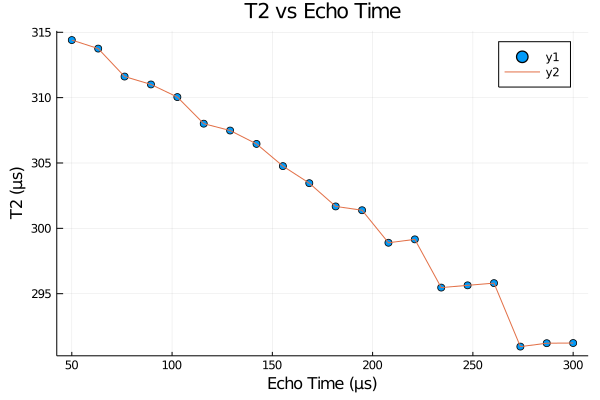

Any[0.0, 0.000193500064499484, 0.00038789183436532506, 0.0005816891339869281, 0.0007760809038527692, 0.0009698782034743721, 0.0011642699733402132, 0.0013580672729618163]
Any[0.0, 0.00020605809296492578, 0.000412413528055342, 0.0006187689631457583, 0.0008251243982361746, 0.001031479833326591, 0.0012378352684170072, 0.0014441907035074235]
Any[0.0, 0.0002159457288422813, 0.00043218526139727315, 0.000648424793952265, 0.0008646643265072569, 0.0010809038590622489, 0.0012971433916172408]
Any[0.0, 0.0002278199956218532, 0.0004565218750977264, 0.000684635832004253, 0.0009133377114801262, 0.0011414516683866528, 0.001370153547862526]
Any[0.0, 0.00024023702031602702, 0.0004807680883925388, 0.0007212991564690506, 0.0009618302245455624, 0.0012023612926220742, 0.0014428923606985859]
Any[0.0, 0.00024856707215278624, 0.0004974235122591846, 0.0007462799523655829, 0.0009951363924719811, 0.0012439928325783795]
Any[0.0, 0.00026026549518730205, 0.0005213995070437497, 0.0007819545077874338, 0.001043088519643

In [143]:
# t2 calculation and plot

using LsqFit
@. model(x,p) = p[1]*exp(-x/p[2])
lb = [0.0, 0.0, 0.001]
ub = [0.5, 1.0, 1.0]

fits = []
p_list = []
t2_list = [];

for i = 1:20
    
    echo_time_h = echo_time[i]
    num_echoes = params["num_echoes"][i]
    
    x = locs[i] # collect(0:num_echoes).*echo_time_h
    println(x)
    y = echo_ints[i]
    p0 = [0.5, 0.0001]
    # fit = curve_fit(model, x, y, p0, lower = lb, upper = ub)
    fit = curve_fit(model, x, y, p0)
    push!(fits, fit)
    
    p = plot()
    t = collect(LinRange(0, 1500e-6, 10000))
    scatter!(p, x, y.*maximum(broadcast(abs, M_list[i]))/maximum(model(t, coef(fit))), label = "Echo Integrals")
    plot!(collect(LinRange(0, 1500e-6, size(M_list[i],1))), broadcast(abs, M_list[i]))
    plot!(p, t, model(t, coef(fit)).*maximum(broadcast(abs, M_list[i]))/maximum(model(t, coef(fit))), label = "Exponential Fit")
    # plot!(p, t, model(t, coef(fit)), label = "Exponential Fit")
    push!(p_list, p)
    push!(t2_list, coef(fit)[2])
    
end

idx = 1
p1 = plot()
scatter!(p1, echo_time*1e6, t2_list*1e6)
plot!(p1, echo_time.*1e6, t2_list*1e6)
title!(p_list[idx], "Echo Time = "*string(echo_time[idx]*1e6)*"μs")
title!(p1, "T2 vs Echo Time")
xlabel!(p1, "Echo Time (μs)")
ylabel!(p1, "T2 (μs)")

new_p = []
for idx = 1:20
    title!(p_list[idx], "Echo Time = "*string(round(echo_time[idx]*1e6, digits = 2))*"μs")
end

[1, 4, 6, 8, 9, 10, 15, 20]

p2 = plot(p_list[1], p_list[4], p_list[6], p_list[8], p_list[10], p_list[12], p_list[15], p_list[18], p_list[20], size = (2000,2000))
savefig("echo_int_max_control.png")

p3 = plot()
scatter!(p3, echo_time*1e6, t2_list*1e6)
plot!(p3, echo_time.*1e6, t2_list*1e6)
title!(p3, "T2 vs Echo Time")
xlabel!(p3, "Echo Time (μs)")
ylabel!(p3, "T2 (μs)")
display(p3)

savefig("t2_vs_te_max_control.png")

In [110]:
@load "α_vs_f_phase_01_M_list.jld2" M_list
S1 = M_list
@load "α_vs_f_phase_03_M_list.jld2" M_list
S2 = M_list

S3 = S1 .+ S2

f_slice = 3
α_slice = 1

p1 = plot(leg = false)
p2 = plot(leg = false)
p3 = plot(leg = false)

plot!(p1, broadcast(real, -S1[α_slice, f_slice][158:end]))
plot!(p1, broadcast(imag, -S1[α_slice, f_slice][158:end]))
title!(p1, "Phase 01 (x, y)")

plot!(p2, broadcast(real, -S2[α_slice, f_slice][158:end]))
plot!(p2, broadcast(imag, -S2[α_slice, f_slice][158:end]))
title!(p2, "Phase 03 (x, -y)")

plot!(p3, broadcast(real, -S3[α_slice, f_slice][158:end]))
plot!(p3, broadcast(imag, -S3[α_slice, f_slice][158:end]))
# plot!(p3, broadcast(abs, S3[α_slice, f_slice]))
title!(p3, "Sum of Phases 01, 03")

plot(p1, p2, p3, layout = (1,3), size = (900,300))

savefig("phase_demo.png")

In [41]:
# t2 calculation and plot

t2_amps = zeros(7,9)

for j = 2:10
    for i = 1:7
        S = M_list[i,j]
        L = length(S)
        x0 = convert(Int64, round(L/3))
        #xL = convert(Int64, round(2*x0 - x0/2))
        #xR = convert(Int64, round(2*x0 + x0/2))
        xL = 2*x0 - 10
        xR = 2*x0 + 10
        t2_amps[i,j-1] = sum(broadcast(abs, S[xL:xR]))
    end
end

using LsqFit
@. model(x,p) = p[1]*exp(-x/p[2])
lb = [0.0, 0.0, 0.001]
ub = [0.5, 1.0, 1.0]

fits = []

for j = 1:7
    x = τ[2:end]
    y = t2_amps[j,:]
    p0 = [0.2, 0.0001]
    # fit = curve_fit(model, x, y, p0, lower = lb, upper = ub)
    fit = curve_fit(model, x, y, p0)
    push!(fits, fit)
end

idx = 1;
t2 = coef(fits[idx])[2]
println(t2)

0.00015978074893375485


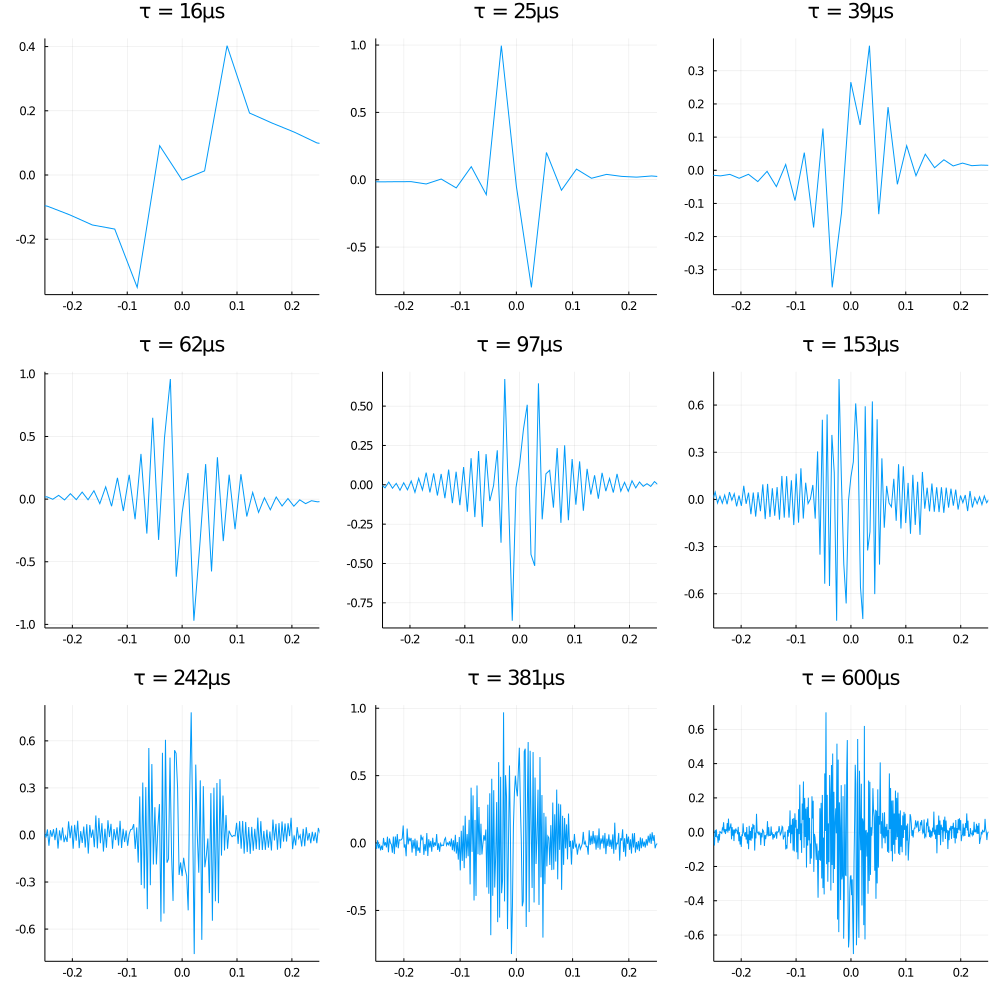

In [184]:
@load "α_vs_f_phase_01_M_list.jld2" M_list
S1 = M_list
@load "α_vs_f_phase_03_M_list.jld2" M_list
S2 = M_list

S3 = S1 .+ S2
using FFTW

x0 = length(M_list[7,10])
slices = zeros(7, x0, 9)
ffts = Array{Any}(undef, 7, 9)
fft_amp = Array{Any}(undef, 7, 9)
fq_ax = Array{Any}(undef, 7, 9)


for i = 1:10
    for j = 1:7
        
        if i == 1
            continue
        end
        
        S = M_list[j,i]
        L = length(S)
        x1 = convert(Int64, round(L/3))
        xL = convert(Int64, round(2*x1 - 0.75*x1))
        xR = convert(Int64, round(2*x1 + 0.75*x1))
        
        fullT = collect(LinRange(0, 3*τ[i]*1e6, L))
        window = fullT[xR] - fullT[xL]
        
        t = LinRange(0, window, size(S[xL:xR], 1));
        dt = t[2]-t[1];
        
        S_trunc = convert(Array{Complex{Float64}}, S[xL:xR])

        # figure out the "frequency axis" after the FFT
        Fs = 1/dt; # 
        N = length(S[xL:xR])
        freq_ax = (((0:N-1) .+ 1/2)/N .- 1/2)*Fs;
        
        S_fft_unscale = fftshift(fft(S_trunc))
        S_fft = S_fft_unscale/maximum(broadcast(abs, S_fft_unscale)) # normalize
        
        l0 = x0 - (xR - xL)
        l1 = convert(Int64, round(l0/2))
        slices[j,l1:(l1+(xR-xL)),i-1] = broadcast(abs, S_fft)
        ffts[j,i-1] = broadcast(real, S_fft)
        fft_amp[j,i-1] = maximum(broadcast(abs, S_fft_unscale)) #sum(broadcast(abs, S_fft))/length(S_fft)
        fq_ax[j,i-1] = freq_ax
        
    end
end

#=
idx1 = 1
idx2 = 3
idx3 = 5
idx4 = 7

shift = 0.75
p1 = plot(size = (900,1000), leg = false)
p2 = plot(size = (900,1000), leg = false)
p3 = plot(size = (900,1000), leg = false)
p4 = plot(size = (900,1000), leg = false)
for i = 1:9
    plot!(p1, slices[idx1, :, i]*0.5/maximum(slices[idx1, :, i]) .+ shift*i)
    plot!(p1, [shift*i], seriestype = :hline)
    plot!(p2, slices[idx2, :, i]*0.5/maximum(slices[idx2, :, i]) .+ shift*i)
    plot!(p2, [shift*i], seriestype = :hline)
    plot!(p3, slices[idx3, :, i]*0.5/maximum(slices[idx3, :, i]) .+ shift*i)
    plot!(p3, [shift*i], seriestype = :hline)
    plot!(p4, slices[idx4, :, i]*0.5/maximum(slices[idx4, :, i]) .+ shift*i)
    plot!(p4, [shift*i], seriestype = :hline)
end
plot!(p1, [x0/2], seriestype = :vline)
plot!(p2, [x0/2], seriestype = :vline)
plot!(p3, [x0/2], seriestype = :vline)
plot!(p4, [x0/2], seriestype = :vline)
xlims!(p1, x0/2 - 100, x0/2 + 100)
xlims!(p2, x0/2 - 100, x0/2 + 100)
xlims!(p3, x0/2 - 100, x0/2 + 100)
xlims!(p4, x0/2 - 100, x0/2 + 100)
title!(p1, "α = "*string(α[idx1]))
title!(p2, "α = "*string(α[idx2]))
title!(p3, "α = "*string(α[idx3]))
title!(p4, "α = "*string(α[idx4]))

plt = plot(p1, p2, p3, p4, layout = (1,4))
display(plt)
display(τ)
=#


p_list = Array{Any}(undef, 7, 9)
for i = 1:7
    for j = 1:9
        p = plot(leg = false)
        plot!(fq_ax[i,j], ffts[i,j])
        xlims!(-0.25,0.25)
        title!("τ = "*string(convert(Int64, round(τ[j+1]*1e6)))*"μs")
        p_list[i,j] = p
    end
end
   
α_idx = 7;
plt = plot(p_list[α_idx,1], p_list[α_idx,2], p_list[α_idx,3], p_list[α_idx,4], p_list[α_idx,5], p_list[α_idx,6], p_list[α_idx,7], p_list[α_idx,8], p_list[α_idx,9], layount = (9,1), size = (1000,1000))


# scatter(τ[2:end], fft_amp[7,:], xscale = :log10)

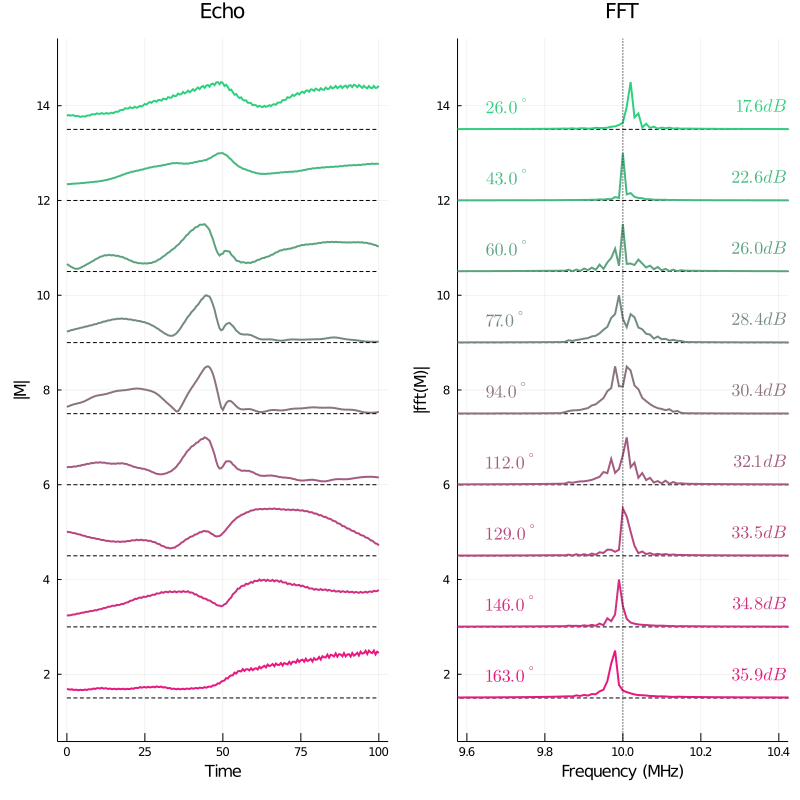

In [123]:
using FFTW
using LaTeXStrings

@load "α_vs_f_phase_01_M_list.jld2" M_list
S1 = M_list
@load "α_vs_f_phase_03_M_list.jld2" M_list
S2 = M_list

S3 = S1 .+ S2
M_list = S3;

idx = 7

M_list = M_list[idx,:]
f = LinRange(0.1, 2, 11)

#tar_alph = 5;
#println(α[tar_alph])
plt1 = plot()
plt2 = plot()
ν0 = params["ν0"]

n_keep = 1;
dt_start = 300;
dt_end = 300;


# loop over the pulse strengths
for f0 = 2:length(f)-1
    
    # load in the M data
    M0 = convert(Array{Complex{Float64}},M_list[f0])
    nt = size(M0, 1);
    xL = nt/5

    # select a truncated window to FFT
    M0_trunc = M0[convert(Int64,round(2*nt/3 - xL)):convert(Int64,round(2*nt/3 + xL))]
    t_max = n_keep*100; # 200 micro seconds
    t = LinRange(0, t_max, size(M0_trunc, 1));
    dt = t[2]-t[1];

    # figure out the "frequency axis" after the FFT
    Fs = 1/dt; # 
    N = length(M0_trunc)
    freq_ax = (((0:N-1) .+ 1/2)/N .- 1/2)*Fs;

    # labeling
    ang_here = (f[f0]*90);
    P0 = f[1]*0.5;
    pulse_str = 10*log(f[f0]/P0)
    db_str = latexstring(string(round(pulse_str,digits=1))*" dB")
    ang_str = latexstring(round(ang_here),"^\\circ");
    color_here = RGB(f0/length(f),1-f0/length(f),0.5)
    
    # plot the time-domian results
    M0_trunc_abs = broadcast(abs,M0_trunc) # normalize
    M0_trunc_abs = M0_trunc_abs/maximum(M0_trunc_abs)
    plot!(plt1,t, M0_trunc_abs .+ 1.5*(length(f)-f0),label="",color=color_here,linewidth=2, xlim=[t[1],t[length(t)]])
    plot!(plt1,t, 0*M0_trunc_abs .+ 1.5*(length(f)-f0),color=RGB(0,0,0),linestyle=:dash,label="")
    
    # FFT!
    M0_fft = fftshift(fft(M0_trunc))

    M0_fft = M0_fft/maximum(broadcast(abs,M0_fft)) # normalize
    plot!(plt2,freq_ax .+ ν0, 0*broadcast(abs,M0_fft) .+ 1.5*(length(f)-f0),color=RGB(0,0,0),linestyle=:dash,label="")
    plot!(plt2,freq_ax .+ ν0,broadcast(abs,M0_fft) .+ 1.5*(length(f)-f0),xlim=ν0 .+ [-0.4,0.4],label="",color=color_here,linewidth=2)

    annotate!(plt2,10.42,0.5+1.5*(length(f)-f0),text(db_str,color_here, :right,12))
    annotate!(plt2,9.65,0.5+1.5*(length(f)-f0),text(ang_str,color_here, :left,12))

end

plot!(plt2,ν0 .+ [0,0],[0, 1.5*(length(f)+1)],color=RGB(0,0,0),label="",linestyle=:dot)

xlabel!(plt1,"Time")
ylabel!(plt1,"|M|")
xlabel!(plt2,"Frequency (MHz)")
ylabel!(plt2,"|fft(M)|")

plot!(plt1,ylim=[1,15])
plot!(plt2,ylim=[1,15])

title!(plt1,"Echo")
title!(plt2,"FFT")

pt = plot(plt1, plt2, size = (800,800))
display(pt)

# α = collect(LinRange(0.05,0.2,9))
# pushfirst!(α, 0)
# display(α[idx])
savefig("α_0p2.png")

In [114]:
α = round.(collect(LinRange(0.1, 0.2, 6)), digits = 2)
pushfirst!(α, 0)

display(α)

7-element Array{Float64,1}:
 0.0
 0.1
 0.12
 0.14
 0.16
 0.18
 0.2